## Training a Unet

In this notebook, we will train a 2D U-net for nuclei segmentation in the Kaggle Nuclei dataset.

It is still possible to do this exercise on the CPU, but you will need some patience to wait for the training. That's why we have added GPU support.
Please switch your Notebook to GPU in Runtime -> change runtime type -> T4 GPU.


## The libraries

In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import imageio

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

## Data loading and preprocessing

For this exercise we will be using the Kaggle 2018 Data Science Bowl data again, but this time we will try to segment it with the state of the art network.
Let's start with loading the data as before.

In [ ]:
# Data download and unzipping
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test

# Suppress output with the -q flag
!unzip -q stage1_train.zip -d stage1_train/
!unzip -q stage1_test.zip -d stage1_test/

# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

--2024-12-10 10:53:44--  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9545388 (9.1M) [application/zip]
Saving to: ‘stage1_test.zip’

stage1_test.zip     100%[===================>]   9.10M  --.-KB/s    in 0.04s   

2024-12-10 10:53:44 (253 MB/s) - ‘stage1_test.zip’ saved [9545388/9545388]

--2024-12-10 10:53:44--  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.


__TASK__: Use `ls` to explore the contents of both folders. Running `ls your_folder_name` should display you what is stored in the folder of your interest.

 How are the images stored? What format do they have? What about the ground truth (the annotation masks)? Which format are they stored in?

Hint: you can use the following function to display the images:

In [ ]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

What one would normally start with in any machine learning pipeline is writing a dataset - a class that will fetch the training samples. In the previous exercises we did not have to worry about it, since we used the classic datasets available in the torchvision library. However, once you switch to using your own data, you would have to figure out how to fetch the data yourself. Luckily most of the functionality is already provided, but what you need to do is to write a class, that will actually supply the dataloader with training samples - a Dataset.

For this exercise you will not have to do it yourself yet, but please carefully read through the provided class:

In [ ]:
# connection between the Colab and the Goggle Drive
from google.colab import drive
root = '/content/gdrive/'
drive.mount( root )

Mounted at /content/gdrive/


In [ ]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [ ]:
def get_data(path, train=True):
    """
    Loads and preprocesses image data.

    Args:
        path (str): Path to the directory containing the image data.
        train (bool, optional): Flag indicating if the data is for training.
                                 Defaults to True.

    Returns:
        tuple or ndarray: If train is True, returns a tuple containing the
                          image data (X) and corresponding masks (Y).
                          If train is False, returns only the image data (X).
    """
    # Get the list of image IDs
    ids = next(os.walk(path))[1]

    # Initialize arrays to store image data and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    # Initialize masks array only if train is True
    if train:
        Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    print('Getting and resizing images ... ')
    sys.stdout.flush()

    # Iterate through each image ID
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        path_new = path + id_

        # Read and resize the image
        img = imread(path_new + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img

        # Read and process masks only if train is True
        if train:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_file in next(os.walk(path_new + '/masks/'))[2]:
                mask_ = imread(path_new + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask

    # Return image data and masks (if train is True) or only image data
    if train:
        return X, Y
    else:
        return X

Now let's load the dataset and visualize it by calling our function:

In this example, we read all images of the train folder as training data (applied SGD on) and all images of the validation folder for testing data (report performance on). Validation data (optimize hyper-parameters on) will be taken randomly from training data during the training process.

In [ ]:
X, Y = get_data(TRAIN_PATH, train=True)
X_test = get_data(TEST_PATH, train=False)

Getting and resizing images ... 


100%|██████████| 670/670 [05:54<00:00,  1.89it/s]

Getting and resizing images ... 



100%|██████████| 65/65 [00:02<00:00, 26.23it/s]


In [ ]:
# Split data into train and validation sets
split_ratio = 0.8  # Example: 80% for training, 20% for validation
split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
Y_train = Y[:split_index]
X_val = X[split_index:]
Y_val = Y[split_index:]

In [ ]:
print(f"Training data shape: X={X_train.shape}, Y={Y_train.shape}")
print(f"Validation data shape: X={X_val.shape}, Y={Y_val.shape}")
print(f"Test data shape: X={X_test.shape}")

Training data shape: X=(536, 256, 256, 3), Y=(536, 256, 256, 1)
Validation data shape: X=(134, 256, 256, 3), Y=(134, 256, 256, 1)
Test data shape: X=(65, 256, 256, 3)


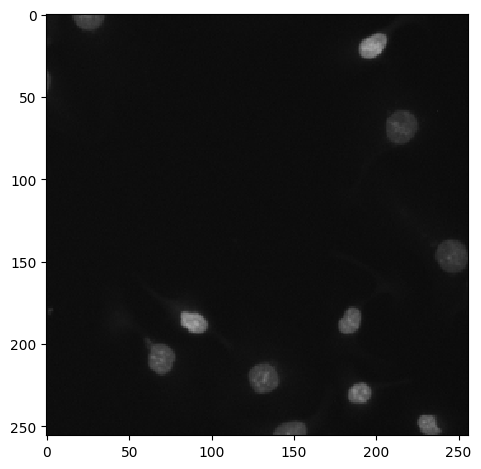

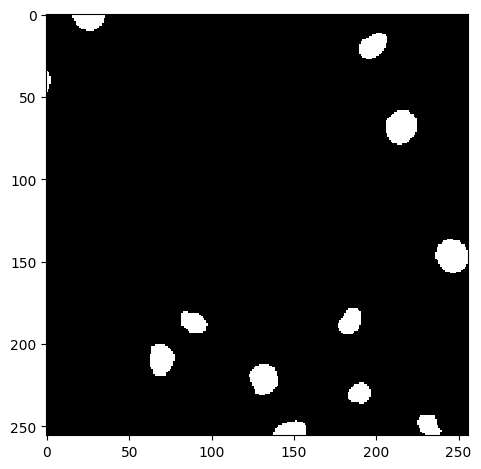

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Building a U-NET model
Now we need to define the architecture of the model to use. This time we will use a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) that has proven to steadily outperform the other architectures in segmenting biological and medical images.

The U-net has an encoder-decoder structure:

In the encoder pass, the input image is successively downsampled via max-pooling. In the decoder pass it is upsampled again via transposed convolutions.

In adddition, it has skip connections, that bridge the output from an encoder to the corresponding decoder.

Note that we are using valid convolutions here; the input to convolutions are not padded and the spatial output size after applying them decreases. Hence, the spatial output size of the network will be smaller than the spatial input size. This could be avoided by using same convolutions, which would increase the computational effort though.

Compared to the paper, we will use less features (channels) to enable training the network on the CPU as well.

In [ ]:
#Each block of u-net architecture consist of two Convolution layers
# These two layers are written in a function to make our code clean
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(x)
    x = Activation("relu")(x)
    return x

In [ ]:
# The u-net architecture consists of contracting and expansive paths which
# shrink and expands the inout image respectivly.
# Output image have the same size of input image
def get_unet(input_img, n_filters):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3) # last layer on encoding path

    # expansive path
    u6 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c5) #upsampling included
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*32, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*16, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*4, kernel_size=3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Loss and distance metrics

The next step to do would be writing a loss function - a metric that will tell us how close we are to the desired output. This metric should be differentiable, since this is the value to be backpropagated. The are [multiple losses](https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/) we could use for the segmentation task.



We use Binary Cross Entropy averaged over pixels as training loss.
This loss function is similar to the cross entropy loss we have used
for the previous classification tasks.

The difference to these tasks is that we predict a single number per pixel
(the probability of this pixel being foreground / background) instead of
a vector per image that encodes the probabilities for several classes.

We also will use the [Dice Coefficeint](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the network predictions.
We can use it for validation if we interpret set $a$ as predictions and $b$ as labels. It is often used to evaluate segmentations with sparse foreground, because the denominator normalizes by the number of foreground pixels.
The Dice Coefficient is closely related to Jaccard Index / Intersection over Union.

In [ ]:
# the coefficient takes values in [0, 1], where 0 is the worst score, 1 is the best score
# the dice coefficient of two sets represented as vectors a, b ca be computed as (2 *|a b| / (a^2 + b^2))
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #Casting to float32 to resolve the type error
    y_true_f = tf.cast(y_true_f, dtype=tf.float32)
    y_pred_f = tf.cast(y_pred_f, dtype=tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    # Ensure denominator is not zero by adding a small value(1e-6) to avoid division by zero errors
    result = (2. * intersection + 1e-6) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + 1e-6)
    return result

In [ ]:
# Creating and Compiling the model
input_img = Input((X_train.shape[1], X_train.shape[2], 3), name='img')
model = get_unet(input_img, n_filters=4)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coefficient])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

Early stopping and model checkpoint

In [61]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

checkpoint_filepath = '/content/gdrive/MyDrive/best_suboptique_model.keras'
Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto') #Callback to save the Keras model or model weights at some frequency.

In [ ]:
!pip install livelossplot

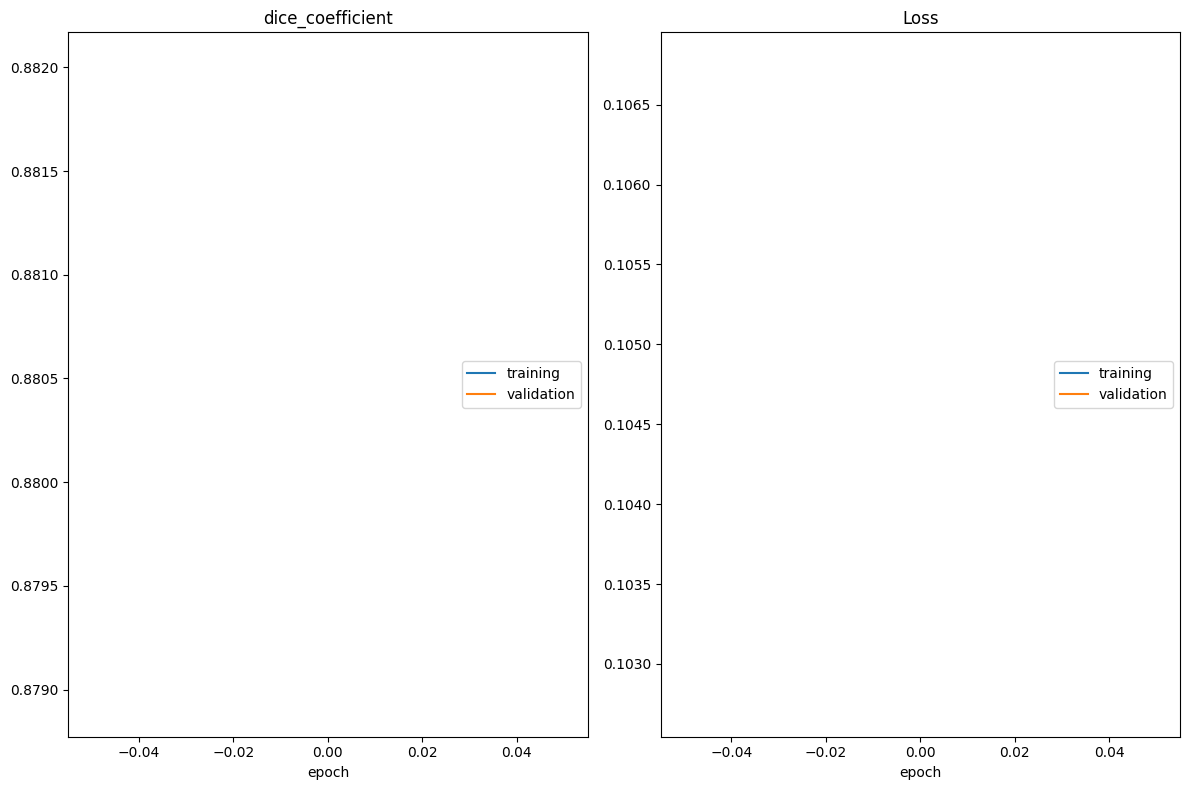

dice_coefficient
	training         	 (min:    0.882, max:    0.882, cur:    0.882)
	validation       	 (min:    0.879, max:    0.879, cur:    0.879)
Loss
	training         	 (min:    0.103, max:    0.103, cur:    0.103)
	validation       	 (min:    0.107, max:    0.107, cur:    0.107)
188/188 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - dice_coefficient: 0.8789 - loss: 0.1071 - val_dice_coefficient: 0.8789 - val_loss: 0.1068
Epoch 2/10
146/188 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - dice_coefficient: 0.9033 - loss: 0.0920

In [ ]:
# Fiting the model
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()
results = model.fit(X_train, Y_train,
                    batch_size=2, epochs=10,
                    validation_split=0.3,
                    verbose=1,
                    callbacks=[plotlossesdeeper])

## Model testing and predictions
Now this is the time to evaluate our training model on test data which the model has never seen them before. In Keras, we can use "model.evaluate" to evaluate the training model where there is an avalibility of masks of test data.

In [ ]:
model_best = tf.keras.models.load_model('/content/gdrive/MyDrive/best_suboptique_model.keras',custom_objects={'dice_coefficient': dice_coefficient})

In [ ]:
model_best.evaluate(X_val,Y_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - dice_coefficient: 0.8934 - loss: 0.1172


[0.10940971970558167, 0.9039284586906433]

In Keras, "model.predict" is the function to predict output (masks in segmentation task or labels in classification task). Then we visualize results and visually compare the predicted masks with the ground truth.

In [ ]:
preds_val = model_best.predict(X_val, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_val_t = (preds_val > 0.3).astype(np.uint8)

In [ ]:
ix = random.randint(0, len(X_val))
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(X_val[ix,:,:,0])
plt.title("input image")
plt.subplot(222)
plt.imshow(np.squeeze(Y_val[ix, :, :, 0]))
plt.title("ground truth")
plt.subplot(223)
plt.imshow(np.squeeze(preds_val[ix, :, :, 0]))
plt.title("Probability map of the predicted mask")
plt.subplot(224)
plt.imshow(np.squeeze(preds_val_t[ix, :, :, 0]))
plt.title("Predicted mask after thresholding")
# show the plot
plt.show()

In [ ]:
preds_test = model_best.predict(X_test, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_t = (preds_test > 0.3).astype(np.uint8)

ix = random.randint(0, len(X_test))
fig = plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(X_test[ix,:,:,0])
plt.title("input image")
plt.subplot(132)
plt.imshow(np.squeeze(preds_test[ix, :, :, 0]))
plt.title("Probability map of the predicted mask")
plt.subplot(133)
plt.imshow(np.squeeze(preds_test_t[ix, :, :, 0]))
plt.title("Predicted mask after thresholding")
# show the plot
plt.show()

## Transfert Learning

### Loading data

In [ ]:
!unzip -q "/content/gdrive/MyDrive/Suboptique/BCCD Dataset with mask.zip" -d BCCD/

In [ ]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/BCCD/BCCD Dataset with mask/train/'
TEST_PATH = '/content/BCCD/BCCD Dataset with mask/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

### Put the data in a shape of DL

In [ ]:
from tqdm import tqdm
def get_data(path, train=True):
    """
    Loads and preprocesses image data.

    Args:
        path (str): Path to the directory containing the image data.
        train (bool, optional): Flag indicating if the data is for training.
                                 Defaults to True.

    Returns:
        tuple or ndarray: If train is True, returns a tuple containing the
                          image data (X) and corresponding masks (Y).
                          If train is False, returns only the image data (X).
    """

    A = [os.path.join(path+'original',ix) for ix in os.listdir(path+'original')]
    B = [os.path.join(path+'mask',ix) for ix in os.listdir(path+'mask')]
    A.sort()
    B.sort()

    A = A[:500]
    B = B[:500]

    # Get the list of image IDs
    # Initialize arrays to store image data and masks
    X = np.zeros((len(A), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    # Initialize masks array only if train is True
    if train:
        Y = np.zeros((len(B), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    print('Getting and resizing images ... ')
    sys.stdout.flush()
    for idx in tqdm(range(len(A)),total=len(A)):
        # Read and resize the image
        img = imread(A[idx])[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[idx] = img

    # Read and process masks only if train is True
    if train:
      mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
      for idx in tqdm(range(len(B)),total=len(B)):
        mask_ = imread(B[idx])
        mask_ = mask_[:,:,0]
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                              preserve_range=True), axis=-1)

        Y[idx] = mask_

    # Return image data and masks (if train is True) or only image data
    if train:
        return X, Y
    else:
        return X

In [ ]:
X, Y = get_data(TRAIN_PATH, train=True)
X_test = get_data(TEST_PATH, train=False)

Getting and resizing images ... 


100%|██████████| 500/500 [00:57<00:00,  8.73it/s]

Getting and resizing images ... 



100%|██████████| 159/159 [00:56<00:00,  2.79it/s]


### Split of data

In [ ]:
# Split data into train and validation sets
split_ratio = 0.8  # Example: 80% for training, 20% for validation
split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
Y_train = Y[:split_index]
X_val = X[split_index:]
Y_val = Y[split_index:]

In [ ]:
print(f"Training data shape: X={X_train.shape}, Y={Y_train.shape}")
print(f"Validation data shape: X={X_val.shape}, Y={Y_val.shape}")
print(f"Test data shape: X={X_test.shape}")

Training data shape: X=(400, 256, 256, 3), Y=(400, 256, 256, 1)
Validation data shape: X=(100, 256, 256, 3), Y=(100, 256, 256, 1)
Test data shape: X=(159, 256, 256, 3)


### Visualization

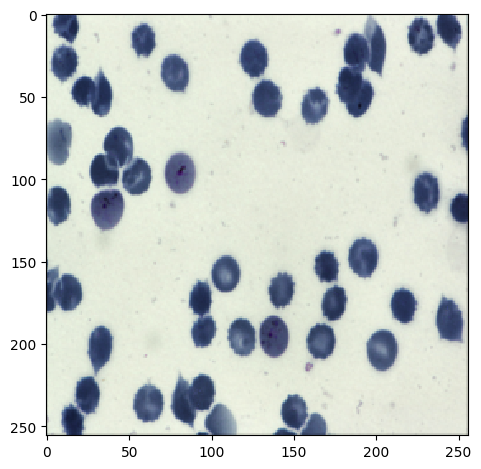

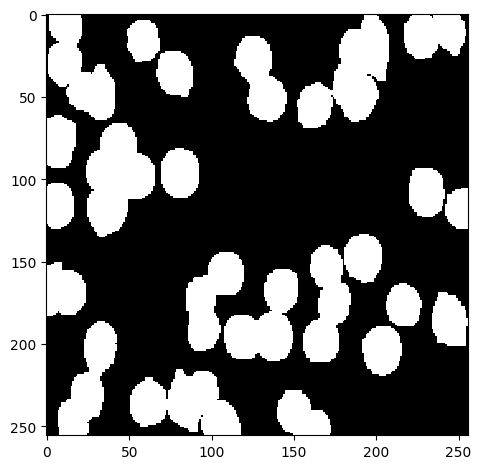

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

### Define model

In [ ]:
model_best = tf.keras.models.load_model('/content/gdrive/MyDrive/best_suboptique_model.keras',custom_objects={'dice_coefficient': dice_coefficient})

TypeError: Error when deserializing class 'Conv2DTranspose' using config={'name': 'conv2d_transpose_8', 'trainable': True, 'dtype': 'float32', 'filters': 96, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv2DTranspose: {'groups': 1}

### Early stopping and model checkpoint

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

checkpoint_filepath = '/content/gdrive/MyDrive/best_transfert_model.keras'
Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto') #Callback to save the Keras model or model weights at some frequency.

### Train model

In [ ]:
# Fiting the model
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()
results = model_best.fit(X_train, Y_train,
                    batch_size=2, epochs=15,
                    validation_split=0.3,
                    verbose=1,
                    callbacks=[plotlossesdeeper])

### Testing model on validation set

In [ ]:
model_best_tr = tf.keras.models.load_model('/content/gdrive/MyDrive/best_transfert_model.keras',custom_objects={'dice_coefficient': dice_coefficient})
model_best_tr.evaluate(X_val,Y_val)

In [ ]:
preds_val = model_best_tr.predict(X_val, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_val_t = (preds_val > 0.3).astype(np.uint8)

In [ ]:
ix = random.randint(0, len(X_val))
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(X_val[ix,:,:,0])
plt.title("input image")
plt.subplot(222)
plt.imshow(np.squeeze(Y_val[ix, :, :, 0]))
plt.title("ground truth")
plt.subplot(223)
plt.imshow(np.squeeze(preds_val[ix, :, :, 0]))
plt.title("Probability map of the predicted mask")
plt.subplot(224)
plt.imshow(np.squeeze(preds_val_t[ix, :, :, 0]))
plt.title("Predicted mask after thresholding")
# show the plot
plt.show()

### Testing model on test data

In [ ]:
preds_test = model_best_tr.predict(X_test, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_t = (preds_test > 0.3).astype(np.uint8)

ix = random.randint(0, len(X_test))
fig = plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(X_test[ix,:,:,0])
plt.title("input image")
plt.subplot(132)
plt.imshow(np.squeeze(preds_test[ix, :, :, 0]))
plt.title("Probability map of the predicted mask")
plt.subplot(133)
plt.imshow(np.squeeze(preds_test_t[ix, :, :, 0]))
plt.title("Predicted mask after thresholding")
# show the plot
plt.show()